In [1]:
from pydriller.repository_mining import RepositoryMining
from pydriller.domain.commit import ModificationType
from pydriller.git_repository import GitRepository
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Convention is: hardcoded strings=uppercase, references to commit *objects* are camel_case
REPO_PATH = "~/gits/logging-log4j2"
FIXING_COMMIT = "5dcc19215827db29c993d0305ee2b0d8dd05939d"
VCC_COMMIT = "e2fcc90ef6749447b1eed5bd1defa76cd497d58a"

In [3]:
initial_commit = next(RepositoryMining(REPO_PATH).traverse_commits())
initial_commit_hash = initial_commit.hash 
fixing_commit = next(RepositoryMining(REPO_PATH, single=FIXING_COMMIT).traverse_commits())
vcc_commit = next(RepositoryMining(REPO_PATH, single=VCC_COMMIT).traverse_commits())
gr = GitRepository(REPO_PATH)

# Q5

## VCC commit info
We start with Q5. Look at the commit information to list the author, plus lines added and removed.

In [4]:
# Get the commit for the VCC
c = next(RepositoryMining(REPO_PATH, single=VCC_COMMIT).traverse_commits())
added = 0
removed = 0
files = []
for m in c.modifications:
    added += m.added
    removed += m.removed
    files.append(m.new_path)
print(f"Author: {c.author.name} ({c.author.email})")
print(f"SHA: {c.hash}")
print(f"Lines added: {added}")
print(f"Lines removed: {removed}")
print(f"Files: {files}")
print(f"Message:\n---\n{c.msg}\n---\n")

Author: Gary D. Gregory (ggregory@apache.org)
SHA: e2fcc90ef6749447b1eed5bd1defa76cd497d58a
Lines added: 58
Lines removed: 11
Files: ['log4j-core/src/main/java/org/apache/logging/log4j/core/net/AbstractLogEventInput.java', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/JSONLogEventInput.java', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/LogEventInput.java', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/SerializedLogEventInput.java', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/TCPSocketServer.java', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/XMLLogEventInput.java']
Message:
---
[LOG4J2-583] TCP and UDP socket servers should be able to handle XML log events. Refactor current code for XML and JSON. Create stubs for XML and JSON implementations.

git-svn-id: https://svn.apache.org/repos/asf/logging/log4j/log4j2/trunk@1582204 13f79535-47bb-0310-9956-ffa450edef68
---



## Number of directories affected in VCC

In [5]:
directories = [m.new_path.replace(m.filename, "") for m in c.modifications]
num_directories = len(set(directories))
print(f"Directories: {directories}")
print(f"Num directories: {num_directories}")
    

Directories: ['log4j-core/src/main/java/org/apache/logging/log4j/core/net/', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/', 'log4j-core/src/main/java/org/apache/logging/log4j/core/net/']
Num directories: 1


## Filter out comments and whitespace

First we try a rudimentary approach to filtering out comments which have been added.
This approach looks for lines starting with `*` `/*` or `*/`. 

In [6]:
added = []
deleted = []
for modifications in c.modifications:
    for m in modifications.diff_parsed["added"]:
        added.append(m)
    for m in modifications.diff_parsed["deleted"]:
        deleted.append(m)
        
comment_starts = ("*", "/*", "*/")

def is_comment(s):
    line = s[1].strip()
    if len(line)==0:
        return True
    if line.startswith(comment_starts):
        return True
    return False

filtered_added = [c for c in added if not is_comment(c)]
filtered_deleted = [c for c in deleted if not is_comment(c)]

print(f"Lines added: {len(filtered_added)}")
print(f"Lines deleted: {len(filtered_deleted)}")

Lines added: 22
Lines deleted: 10


We see this gives the same result as our manual approach given in task 5. 

## More sophisticated approach

We can try a more sophisticated approach using a python library called `comment_parser`. This can be found here: https://github.com/jeanralphaviles/comment_parser/ 

### Additions

In [19]:
import magic
from comment_parser import comment_parser

added = 0
# Loop over each modification
for modifications in vcc_commit.modifications:
    # Look at the *after* code, and generate a list of which lines contain comments
    after_comment_lines = []
    comments = comment_parser.extract_comments_from_str(modifications.source_code)
    for comment in comments:
        line_no = comment.line_number()
        num_lines = len(comment.text().splitlines())
        for i in range(line_no, line_no+num_lines):
            after_comment_lines.append(i)
    # Compare this to the lines added. For each line added which is not a comment, increase our counter. 
    for m in modifications.diff_parsed["added"]:
        if m[0] in after_comment_lines:
            pass
        else:
            if len(m[1])>0:
                added +=1 
# Print the result
print(added)

22


### Deletions

We see this gives the same result as our manual approach given in task 5. Now apply the same approach for deletions.

In [8]:
import magic
from comment_parser import comment_parser

deleted = 0
# Loop over each modification
for modifications in vcc_commit.modifications:
    # Look at the *after* code, and generate a list of which lines contain comments
    before_comment_lines = []
    before = modifications.source_code_before
    if before:
        comments = comment_parser.extract_comments_from_str(before)
        for comment in comments:
            line_no = comment.line_number()
            num_lines = len(comment.text().splitlines())
            for i in range(line_no, line_no+num_lines):
                before_comment_lines.append(i)
        # Compare this to the lines added. For each line added which is not a comment, increase our counter. 
        for m in modifications.diff_parsed["deleted"]:
            if m[0] in before_comment_lines:
                pass
            else:
                if len(m[1])>0:
                    deleted +=1 
# Print the result
print(deleted)

10


We could refactor this to enable better code reuse. We haven't done that here. 

## Days between VCC and previous commit

In [9]:
commits = RepositoryMining(REPO_PATH, to_commit=VCC_COMMIT, order="reverse").traverse_commits()
for index, commit in enumerate(commits):
    if index>1:
        break
    print("---")
    print(commit.author_date)
    print(commit.msg)
    print("---\n")

---
2014-03-27 06:06:20+00:00
[LOG4J2-583] TCP and UDP socket servers should be able to handle XML log events. Refactor current code for XML and JSON. Create stubs for XML and JSON implementations.

git-svn-id: https://svn.apache.org/repos/asf/logging/log4j/log4j2/trunk@1582204 13f79535-47bb-0310-9956-ffa450edef68
---

---
2014-03-27 05:43:45+00:00
Add license header.

git-svn-id: https://svn.apache.org/repos/asf/logging/log4j/log4j2/trunk@1582196 13f79535-47bb-0310-9956-ffa450edef68
---



No need to parse these dates. They clearly occur on the same day. 

In [10]:
file_path = "log4j-core/src/main/java/org/apache/logging/log4j/core/net/SerializedLogEventInput.java"
commits = RepositoryMining(REPO_PATH, to_commit=VCC_COMMIT, order="reverse", filepath=file_path).traverse_commits()
# Perform additional filtering to ensure no we only print commits containing the file_path. 
# The filepath parameter was certainly filtering out many commits, but was not guaranteed to only include the ones we were looking for. 
for index, commit in enumerate(commits):
    in_path = False
    for m in commit.modifications:
        if m.new_path==file_path:
            in_path = True
    if in_path:
        print("---")
        print(commit.author_date)
        print(commit.author.name)
        print(commit.author.email)
        print(commit.msg)
        print(f"SHA: {commit.hash}")
        print("---")

## Author history

This particular operation was more difficult with pydriller, so we use the gitpython object available through PyDriller's GitRepository object. 

Otherwise, this code basically copied verbatim from the Workshop demo. 


   Commit           Author
0    1066  Gary D. Gregory
1     659      Ralph Goers
2     168           rpopma
3     107     nickwilliams
4      66       mattsicker


<AxesSubplot:xlabel='Commit', ylabel='Author'>

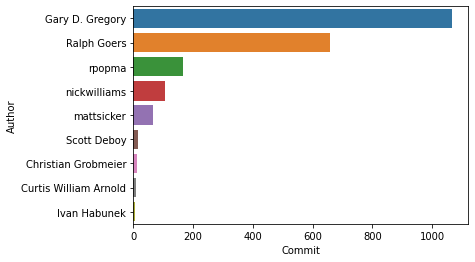

In [11]:
repo = gr.repo
commit_authors = repo.git.shortlog("-n", "-s", VCC_COMMIT).splitlines()
author_commits = []

for commit_author in commit_authors:
    commit, author = commit_author.split("\t")
    author_commits.append([int(commit), author])
df = pd.DataFrame(author_commits, columns=['Commit', 'Author'])
print(df.head())
sns.barplot(y='Author', x="Commit", data=df)

# Q3

We now return to Q3. 

In [12]:
# First list the files changed
for c in  fixing_commit.modifications:
    print(c.filename)

AbstractSocketServer.java
ObjectInputStreamLogEventBridge.java
TcpSocketServer.java
UdpSocketServer.java
FilteredObjectInputStream.java


In [13]:
# Choose the file ObjectInputStreamLogEventBridge.java from our PDF report
# Get the modifications to our chosen file
files = [m for m in fixing_commit.modifications if m.filename=="ObjectInputStreamLogEventBridge.java"]
# Make sure the filter only finds one file
assert len(files)==1
fixing_modification = files[0]
# Just another assertion to make sure our code is working properly
assert fixing_modification.change_type == ModificationType.MODIFY
diffs = fixing_modification.diff_parsed

In [14]:
dodgy_commits_dl = []  # Collect dodgy commits from deleted lines
# Handle deleted lines first
# Run blame on the parent of the FIXING_COMMIT commit
prev_blame = gr.repo.blame(f"{FIXING_COMMIT}^", file=fixing_modification.old_path)
commits = [] # Each index corresponds to a line number
for blame in prev_blame:
    for line in blame[1]:
        commits.append(blame[0].hexsha)
for diff in diffs["deleted"]:
    line_number = diff[0]
    commit = commits[line_number]
    dodgy_commits_dl.append(commit)
print(f"Dodgy commits from deleted lines: {dodgy_commits_dl}")

Dodgy commits from deleted lines: ['5a80ae1c7cb69204912ef104201d3a5e3f2856e3', 'e2fcc90ef6749447b1eed5bd1defa76cd497d58a']


In [15]:
dodgy_commits_al = []  # Collect dodgy commits from added lines
# Now look at added lines
# Choosing the scope to be the wrapStream function, as per the report.
diff = gr.repo.git.log(FIXING_COMMIT, "-L", f":wrapStream:{fixing_modification.new_path}")
diff_hashes = [line.replace("commit ", "") for line in diff.split('\n') if "commit" in line]
# We take the most recent, as per our report
dodgy_commits_al.append(diff_hashes[1])
print(f"Dodgy commits from added lines: {dodgy_commits_al}")

Dodgy commits from added lines: ['f0781690f7e9ee1bf6344093c1edaf53191d0d52']


We see that, in total, three possible VCC commits are identified with equal frequency. The commit we identified in our report (e2fcc90) is present. 

## A different approach
The PyDriller library has a function get_commits_last_modified_lines which applies the SZZ algorithm to `returns the set of commits that last “touched” the lines that are modified in the files included in the commit`

In [16]:
commit = gr.get_commit(FIXING_COMMIT)
buggy_commits_by_file = gr.get_commits_last_modified_lines(commit)
buggy_commits = list(buggy_commits_by_file["log4j-core/src/main/java/org/apache/logging/log4j/core/net/server/ObjectInputStreamLogEventBridge.java"])
print(buggy_commits)


['e2fcc90ef6749447b1eed5bd1defa76cd497d58a', '5e48367f9075a5672cac247f74434295e58459f6']


We see that the first commit is the one we identified in our report. 
But`5e4836` is new and was not identified in our earlier analysis. 
Let's take a look. 

In [17]:
c = next(RepositoryMining(REPO_PATH, single="5e4836").traverse_commits())

In [18]:
print(c.author.name)
print(c.author_date)
print(c.msg)
files = [m for m in c.modifications if m.filename=="ObjectInputStreamLogEventBridge.java"]
pprint(files[0].diff_parsed)

Gary D. Gregory
2014-05-13 17:36:12+00:00
The commit has interdependent changes for:
- [LOG4J2-634] ThrowableProxy ctor throws an exception when using suppressed exceptions.
- [LOG4J2-584] TCP and UDP socket servers should be able to handle JSON log events
- [LOG4J2-583] TCP and UDP socket servers should be able to handle XML log events
General:
- The Jackson code is 100% non-intrusive to the API and Core types. Jackson mix-ins are used for all IO specifications.
Details for log4j-api:
- Log4jMarker is public so it can be accessed Jackson XML and JSON IO code.
Details for log4j-core:
- The POM now depends on the JSON and XML databindings. Note that the runtime only needs Jackson if the JSON or XML layout or listeners are used.
- The class StackTracePackageElement has been renamed ExtendedStackTraceElement and tracks the StackTraceElement it conceptually extends. StackTraceElement is a final JRE class so we use composition. This allows (de)serialization to deal with the extended stack t

This occurs over two weeks earlier than the VCC we identified in our report. 